In [1]:
import Pkg; Pkg.activate("../.")

using Revise
using DeconvMultiStep

using FITSIO
using Plots
default(titlefontsize = 10) 

using Random
Random.seed!(1234)

  Activating project at `~/Desktop/En cours !/Simon/DeconvMultiStep/DeconvMultiStep.jl`
┌ Info: Precompiling DeconvMultiStep [d89ecc27-71de-4448-a14f-b03cf4894fbc]
└ @ Base loading.jl:1662


TaskLocalRNG()

## Make UV planes

# short bases: 4871
# long bases: 14897


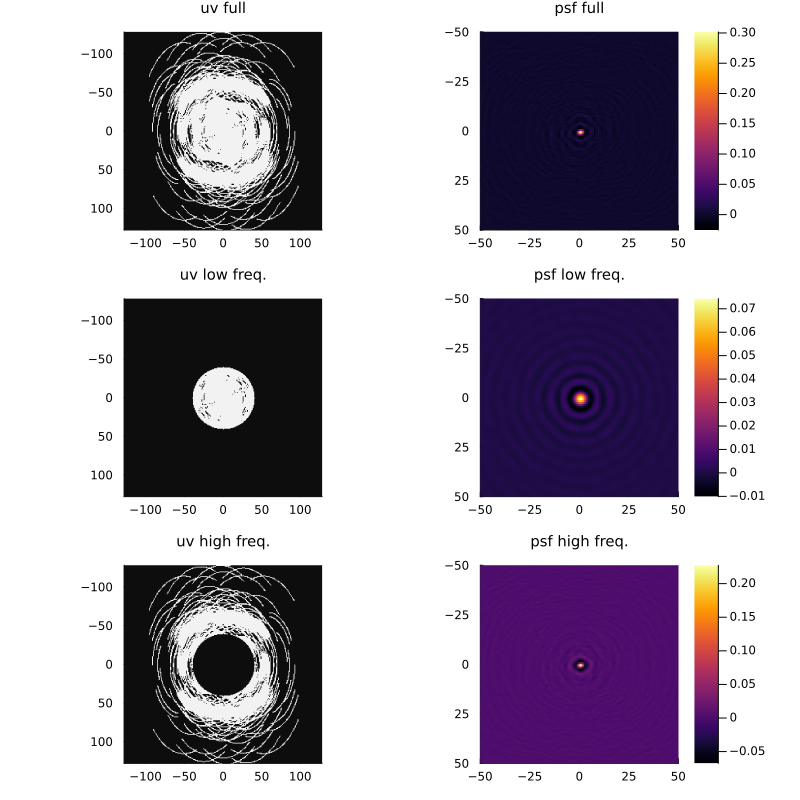

In [3]:
# number of antennas
n_ants = 128

# baseline threshold (in pixels)
ℓ = 40.0

# sky file

# sky = Float64.(dropdims(read(FITS("m31_sky.fits")[1]); dims=3))
# sky = Float64.(read(FITS("lena.fits")[1]))
sky = Float64.(read(FITS("Meerkat_Galactic_center_256.fits")[1]))
sky /= maximum(sky)
n_pix,  = size(sky)

# make all bases

bases = make_bases("uvgen-test.txt", 256)

# split bases and make psf's

psf, uv = make_psf(bases, n_pix,  ℓ) 
println("# short bases: $(sum(uv.low))")
println("# long bases: $(sum(uv.high))")

p1 = imshow_uv(uv.full, title="uv full")
p2 = imshow_psf(psf.full, zoom = 50, title="psf full")

p3 = imshow_uv(uv.low, title="uv low freq.")
p4 = imshow_psf(psf.low, zoom=50,  title="psf low freq.")

p5 = imshow_uv(uv.high, title="uv high freq.")
p6 = imshow_psf(psf.high, zoom=50, title="psf high freq.")

p7 = plot(p1, p2, p3, p4, p5, p6, layout=(3,2), size = (800, 800))
# savefig(p7, "../../paper/figs/uv_psf.png")

## Make dirty images

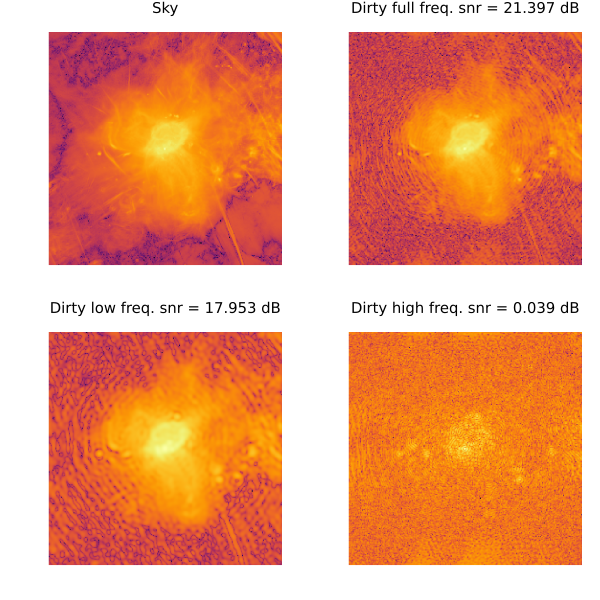

In [22]:
dirty = make_dirty(psf, sky, 0.0)

p1 = imshow(log.(abs.(sky)), title = "Sky")
p2 = imshow(log.(abs.(dirty.full)), title = "Dirty full freq. snr = $(snr(sky, dirty.full)) dB")
p3 = imshow(log.(abs.(dirty.low)), title = "Dirty low freq. snr = $(snr(sky, dirty.low)) dB")
p4 = imshow(log.(abs.(dirty.high)), title = "Dirty high freq. snr = $(snr(sky, dirty.high)) dB")

p5 = plot(p1, p2, p3, p4, layout = (2,2), size = (600, 600))
#savefig(p5, "../../paper/figs/dirty.png")

## Deconv with all visibilitie

Computing... 100%|███████████████████████████████████████| Time: 0:00:17


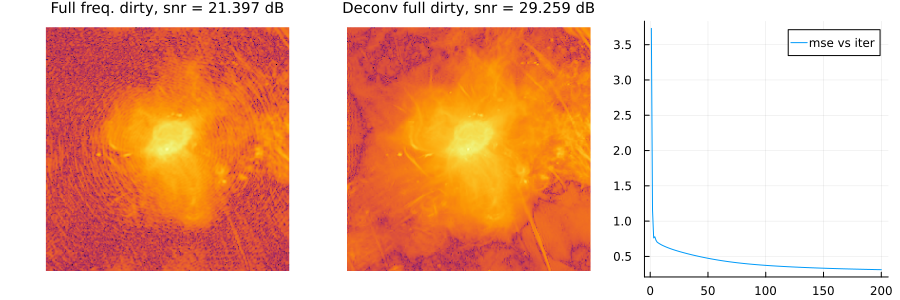

In [23]:
η = compute_step(psf.full)
i_full, mse = fista(psf.full, dirty.full, 1e-5, 200, η; sky=sky)

p1 = imshow(log.(abs.(dirty.full)), title="Full freq. dirty, snr = $(snr(sky, dirty.full)) dB")
p2 = imshow(log.(abs.(i_full)), title = "Deconv full dirty, snr = $(snr(sky, i_full)) dB")
p3 = plot(mse, label = "mse vs iter")
p4 = plot(p1, p2, p3, layout=(1,3), size = (900, 300))

# savefig(p4, "../../paper/figs/recon_full.png")

## Deconv with low frequencies

In [29]:
η = compute_step(psf.low)
i_low, mse = fista(psf.low, dirty.low, 1e-4, 100, η; sky=sky)
    
p1 = imshow(log.(abs.(dirty.low)), title="Low freq. dirty, snr = $(snr(sky, dirty.low)) dB")
p2 = imshow(log.(abs.(i_low)), title = "Deconv low freq., snr = $(snr(sky, i_low)) dB")
p3 = plot(mse, label = "mse vs iter")
p4 = plot(p1, p2, p3, layout=(1,3), size = (900, 300))

savefig(p4, "../../paper/figs/recon_low.png")

Computing... 100%|███████████████████████████████████████| Time: 0:00:08


"/Users/ferrari/Desktop/En cours !/Simon/DeconvMultiStep/paper/figs/recon_low.png"

## Add high frequencies

In [30]:
G = sqrt(sum(uv.high)/sum(uv.low))*low_pass(ℓ, n_pix)

η = compute_step(psf.high; G=G)
i_multistep, mse = fista(psf.high, dirty.high, 1e-4, 200, η; G=G, i₀ = i_low, sky=sky)

p1 = imshow(log.(abs.(i_low)), title="Deconv low freq., snr = $(snr(sky, dirty.high)) dB")
p2 = imshow(log.(abs.(i_multistep)), title = "Estimated sky, snr = $(snr(sky, i_multistep)) dB")
p3 = plot(mse, label = "mse vs iter")
p4 = plot(p1, p2, p3, layout=(1,3), size = (900, 300))

# savefig(p4, "../../paper/figs/recon_2steps.png")

Computing... 100%|███████████████████████████████████████| Time: 0:00:21


"/Users/ferrari/Desktop/En cours !/Simon/DeconvMultiStep/paper/figs/recon_2steps.png"